# Quickstart for MNIST-1D
Sam Greydanus

This notebook shows how to build the MNIST-1D dataset and train some baselines*.

_* If you're running this in Colab, it's best to use a GPU runtime._

In [1]:
!python -m pip install git+https://github.com/michael-beebe/mnist1d.git@master
    
# Download repo directly (gives access to notebooks/models.py and notebooks/train.py)
!git clone https://github.com/michael-beebe/mnist1d

  Cloning https://github.com/michael-beebe/mnist1d.git (to revision master) to /private/var/folders/_j/bzxyr3ts7c9gfmyhzsbnz_cc0000gn/T/pip-req-build-0p7oa8f2
  Running command git clone --filter=blob:none --quiet https://github.com/michael-beebe/mnist1d.git /private/var/folders/_j/bzxyr3ts7c9gfmyhzsbnz_cc0000gn/T/pip-req-build-0p7oa8f2
  Resolved https://github.com/michael-beebe/mnist1d.git to commit 81a06b84de3c3c95c01271f55e1ee9c08993152d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.post119-py3-none-any.whl size=14552 sha256=a42706b6d0f04027fdec5b43eedce6002955eb84100f43a51ebc6df378aeb309
  Stored in directory: /private/var/folders/_j/bzxyr3ts7c9gfmyhzsbnz_cc0000gn/T/pip-ephem-wheel-cache-jx9nzehw/wheels/65/81/73/b12455867801a215d9fa1c4e653a742e50a84abe06d1697bca
Successfully built mnist1d
  Attempting uninstall: mnist1d
    Found existing insta

In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('./mnist1d/mnist1d') ; sys.path.append('./mnist1d/notebooks')
import mnist1d

from mnist1d.data import get_templates, get_dataset_args, get_dataset
from train import get_model_args, train_model
from models import ConvBase, GRUBase, MLPBase, LinearBase, ResNet1DBase, TCNBase, DilatedCNNBase
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

# Try attaching to GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', DEVICE)

Using: cpu


## Step 1: Visualize templates
To construct MNIST-1D, we start with ten 1D signals, each of which resembles a digit in the range 0-9.

Templates for the MNIST-1D dataset:


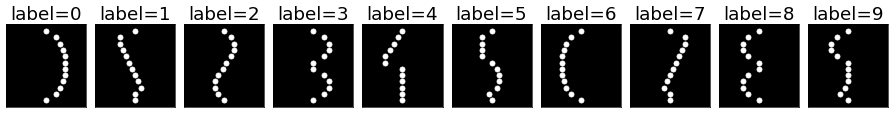

In [3]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

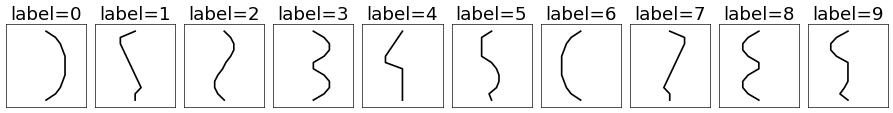

In [4]:
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=False)

## Step 2: Transform

Now we are going to transform these signals in such a way that they become difficult to classify. Nonlinear representations and good spatial priors will become very important in order to classify them.

In [5]:
get_dataset_args(as_dict=True)

{'num_samples': 5000,
 'train_split': 0.8,
 'template_len': 12,
 'padding': [36, 60],
 'scale_coeff': 0.4,
 'max_translation': 48,
 'corr_noise_scale': 0.25,
 'iid_noise_scale': 0.02,
 'shear_scale': 0.75,
 'shuffle_seq': False,
 'final_seq_length': 40,
 'seed': 42,
 'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}

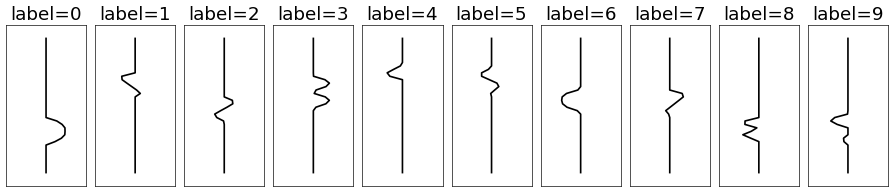

In [6]:
arg_dict = get_dataset_args(as_dict=True)

arg_dict['padding'] = [36, 60]
arg_dict['max_translation'] = 48
arg_dict['scale_coeff'] = 0
arg_dict['corr_noise_scale'] = 0
arg_dict['iid_noise_scale'] = 0
arg_dict['shear_scale'] = 0
args = ObjectView(arg_dict)

x = templates['x']
t = templates['t']
y = templates['y']
set_seed(args.seed)
fig = plot_signals(x, t, labels=y, args=args, ratio=2.2, do_transform=True)

## Step 3: Make a dataset
Next we are going to construct a classification dataset, analogous to MNIST but much smaller, using these signals. Note that the dataset gets saved as a small pickle file, so you don't have to build it from scratch every time.

In [7]:
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d/mnist1d_data_custom.pkl', download=False, regenerate=True)

Did or could not load data from ./mnist1d/mnist1d_data_custom.pkl. Rebuilding dataset...


In [8]:
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d/mnist1d_data_custom.pkl', download=False, regenerate=False)

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Successfully loaded data from ./mnist1d/mnist1d_data_custom.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40
Number of classes: 10


## Step 3b: Download the baseline dataset
It's always possible that the open-source libraries that we used to synthesize this dataset will change. Even if they change slightly, the dataset one obtains from running the code above may change slightly, making it hard for you and I to compare results.

If you want to use MNIST-1D as a baseline, we suggest that you load it using the pickle file provided in the repo. The dataset contained in that file will serve as the one-and-only, original MNIST1D dataset. The link is https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl. The `mnist1d.get_dataset` function loads this file when `download` is set to `True`:

In [9]:
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl


## Step 4: Run baselines*

We'll see that:
* Nonlinear classifiers do better than linear classifiers.
* Classifiers with transformation invariance and local connectivity (CNNs) do better than ones without these properties (MLPs).

An additional note:
* Humans do just a bit better than the other baselines (human performance is 95.8% on 500 test set examples). This suggests that shortcut learning and memorization don't help much.

_*You may see slightly different numbers than the ones from the default run. This is due to the fact that you are using a GPU instead of CPU: PyTorch's random seeding function ``torch.cuda.manual_seed_all(seed)`` causes this difference. Your results will be reproducible between GPUs._

In [10]:
get_model_args(as_dict=True)

{'input_size': 40,
 'output_size': 10,
 'hidden_size': 256,
 'learning_rate': 0.01,
 'weight_decay': 0,
 'batch_size': 100,
 'total_steps': 8000,
 'print_every': 1000,
 'eval_every': 250,
 'checkpoint_every': 1000,
 'device': 'cpu',
 'seed': 42}

In [11]:
# --- Note: if you run on a GPU, the walltimes will be _much_ lower

args = get_model_args()
args.total_steps = 6000
# args.total_steps = 1000
args.device = DEVICE

set_seed(args.seed)
model = ConvBase(output_size=args.output_size)
results_cnn = train_model(data, model, args)
print()

set_seed(args.seed)
model = GRUBase(input_size=1, output_size=args.output_size)
results_gru = train_model(data, model, args)
print()

set_seed(args.seed)
model = MLPBase(args.input_size, args.output_size)
results_mlp = train_model(data, model, args)
print()

set_seed(args.seed)
model = LinearBase(args.input_size, args.output_size)
results_lin = train_model(data, model, args)
print()

#############################################
#                New models
#############################################
# set_seed(args.seed)
# model = ResNet1DBase(input_size=args.input_size, output_size=args.output_size)
# results_resnet = train_model(data, model, args)
# print()

# --- TODO: get TCN working, experiment with different num_channels
# set_seed(args.seed)
# model = TCNBase(input_size=args.input_size, output_size=args.output_size, num_channels=[25, 25, 25])
# results_tcn = train_model(data, model, args)
# print()

# ---- TODO: get DilatedCNN working
# set_seed(args.seed)
# model = DilatedCNNBase(input_size=args.input_size, output_size=args.output_size)
# results_dilated_cnn = train_model(data, model, args)
# print()

Initialized ConvBase model with 5210 parameters
step 1000, dt 5.24s, train_loss 6.157e-02, test_loss 3.751e-01, train_acc 97.2, test_acc 89.9
step 2000, dt 4.94s, train_loss 5.304e-02, test_loss 3.190e-01, train_acc 99.7, test_acc 93.5
step 3000, dt 4.98s, train_loss 8.589e-04, test_loss 2.930e-01, train_acc 100.0, test_acc 95.2
step 4000, dt 5.39s, train_loss 1.980e-04, test_loss 2.569e-01, train_acc 100.0, test_acc 95.2
step 5000, dt 4.87s, train_loss 7.601e-05, test_loss 2.635e-01, train_acc 100.0, test_acc 95.4
step 6000, dt 4.70s, train_loss 3.455e-05, test_loss 2.709e-01, train_acc 100.0, test_acc 96.0

Initialized GRUBase model with 5134 parameters
step 1000, dt 7.45s, train_loss 1.875e-01, test_loss 3.634e-01, train_acc 93.5, test_acc 88.5
step 2000, dt 7.50s, train_loss 8.917e-02, test_loss 4.566e-01, train_acc 94.3, test_acc 88.6
step 3000, dt 7.49s, train_loss 6.011e-02, test_loss 5.145e-01, train_acc 96.2, test_acc 87.1
step 4000, dt 7.52s, train_loss 5.250e-02, test_loss 4

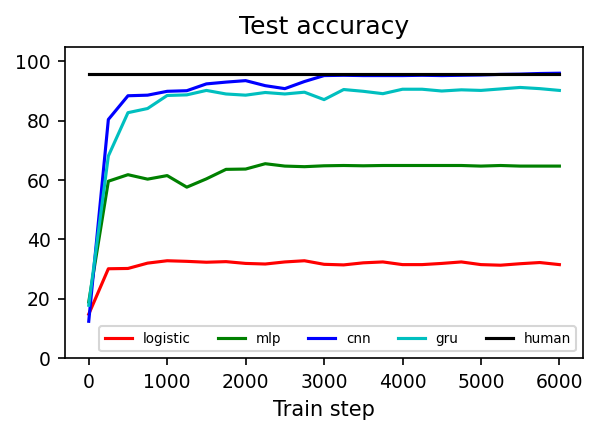

In [13]:
fig = plt.figure(figsize=(4.1, 3), dpi=150)

plt.subplot(1,1,1)
t = range(0, args.total_steps+1, args.eval_every)
plt.plot(t, results_lin['test_acc'], 'r-', label='logistic')
plt.plot(t, results_mlp['test_acc'], 'g-', label='mlp')
plt.plot(t, results_cnn['test_acc'], 'b-', label='cnn')
plt.plot(t, results_gru['test_acc'], 'c-', label='gru')

# --- New models
# plt.plot(t, results_resnet['test_acc'], 'm-', label='resnet')
# plt.plot(t, results_tcn['test_acc'], 'y-', label='tcn')
# plt.plot(t, results_dilated_cnn['test_acc'], 'k-', label='dilated_cnn')

plt.plot(t, [95.8]*len(t), 'k-', label='human')

plt.title('Test accuracy') ; plt.xlabel("Train step") ; plt.legend(fontsize=6.5, ncol=5, loc='lower right')
plt.xticks(fontsize=9) ; plt.yticks(fontsize=9)
plt.ylim(0,105)
plt.tight_layout() ; plt.show()

## Step 5: Conclusions
We believe this dataset is ideal for performing small-scale, "science of deep learning" experiments.

Try it out, do something interesting, and share it with us via a Colab. We would like to feature your work in our README.